# California Housing Project

This lab shows the importance of location in the pricing of housing in California, showing that location along can account for 75% of the variation in housing prices. 
- The **first model** considers the house's simple geographic region and accounts for **20%** of the variation in housing price.
- The **second model** considers the house's distance to large cities and accounts for **25%** of variation.
- The **final model** considers the price of nearby homes and accounts for **75%** of the variation.

## EDA
Load the dataset, look for correlation between housing features and housing price


In [97]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from geopy.distance import geodesic

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [15]:
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["housing_price"] = pd.DataFrame(housing.target, columns=housing.target_names)
df.dropna(axis=1, inplace=True)
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  housing_price  
0    -122.23          4.526  
1    -122.22          3.585  
2    -122.24          3.521  
3    -122.25          3.413  
4    -122.25          3.422

We see a **strong correlation** of both **Medium Income** (MedInc) **location** with housing price.  The highest priced housing can be found in the San Francisco, L.A., and San Diego regions, while the lower priced housing is in the Central Valley.

In [124]:
x = pd.DataFrame(df[["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "housing_price"]].corr()["housing_price"])
x.columns=["Price Correlation"]
x.drop("housing_price").sort_values(by="Price Correlation", ascending=False)

Price Correlation
MedInc               0.688075
AveRooms             0.151948
HouseAge             0.105623
AveOccup            -0.023737
Population          -0.024650
AveBedrms           -0.046701

In [ ]:
px.scatter_map(df, lat="Latitude", lon="Longitude", color="housing_price")

## First Simple Model: Region of Housing
As a simple initial model, we will model housing_price by 5 regions, which ultimately accounts for 20% of the variation in housing price.
The model assigns these housing prices based on region, as discovered during model fitting:
- San Francisco Region:
- Los Angeles Region:
- San Diego Region:
- Central Valley Region:
- Other Region: 

First, determine whether each housing block falls in a particular region.  Then, build and inspect a linear model of housing prices.

In [23]:
regions = {"sf_region": {"h":(38.09, -122.61), "k":(36.96, -121.99), "r":95},
           "la_region": {"h":(34.11, -118.51), "k":(33.85, -117.85), "r":60},
           "sd_region": {"h":(33.09, -117.14), "k":(32.67, -117.01), "r":42},
           "central_valley": {"h":(38.83, -121.18), "k":(36.5, -119.36), "r":194}}

def in_region(region, point):
    return (geodesic(region["h"], point).mi + geodesic(region["k"], point).mi) < region["r"]

for region in regions:
    df[region] = df[["Latitude", "Longitude"]].apply(lambda x: in_region(regions[region], (x[0], x[1])), axis=1);

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/1577517323.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/1577517323.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/1577517323.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df[["sf_region", "la_region", "sd_region", "central_valley"]], df["housing_price"], 
                                                    test_size=0.2, random_state=42)

lr = LinearRegression()

lr.fit(X_train, y_train)

print("Model Score:", round(lr.score(X_test, y_test), 3))
print("Coefficients:", list(zip(lr.feature_names_in_, lr.coef_)))
print("Intercept:", lr.intercept_)


Model Score: 0.195
Coefficients: [('sf_region', 1.2096907972104924), ('la_region', 0.7621050993520639), ('sd_region', 0.3472490981707543), ('central_valley', -0.552416955969014)]
Intercept: 1.628394228696274


In [71]:
samples = np.vstack([np.identity(4), [0,0,0,0]])
samples = pd.DataFrame(samples, columns=X_train.columns)
samples.index = ["SF Region", "LA Region", "SD Region", "Central Valley", "Other"]

predictions = lr.predict(samples)
pd.DataFrame(zip(samples.index, predictions), columns=["Region", "Housing Price ($ millions)"])


Region  Housing Price ($ millions)
0       SF Region                    2.838085
1       LA Region                    2.390499
2       SD Region                    1.975643
3  Central Valley                    1.075977
4           Other                    1.628394

In [98]:
df["model_one_residuals"] = df["housing_price"] - lr.predict(df[["sf_region", "la_region", "sd_region", "central_valley"]])
px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_one_residuals")

## Second Simple Model: Inverse Distance to City
This model looks at price compared the to inverse distance to several desirable cities to live.

In [84]:
desirable_cities = {"san_rafael": (37.97,-122.53), "san_francisco": (37.77, -122.45), 
                    "san_mateo":(37.55, -122.31), "redwood_city": (37.43, -122.13),
                    "mountain_view":(37.37, -122.07), "cupertino": (37.32, -122.02),
                    "montery":(36.59, -121.93), "santa_barbara": (34.41, -119.71),
                    "la_beach":(33.82, -118.38),
                    "santa_monica":(34.03, -118.47), "san_diego": (32.08, -117.24)}

def inverse_distance(location, desirable_city):
    return 1/(1+geodesic(location, desirable_city).mi)

In [85]:
for city in desirable_cities:
  df[city] = df[["Latitude", "Longitude"]].apply(lambda x: inverse_distance(desirable_cities[city], (x[0], x[1])), axis=1)

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/3856940522.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/3856940522.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_27122/3856940522.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[desirable_cities.keys()], df["housing_price"], test_size=0.2)

lr_model_two = LinearRegression()

lr_model_two.fit(X_train, y_train)
lr_model_two.score(X_test, y_test)

0.3057008947704889

<Axes: xlabel='model_two_residuals', ylabel='Count'>

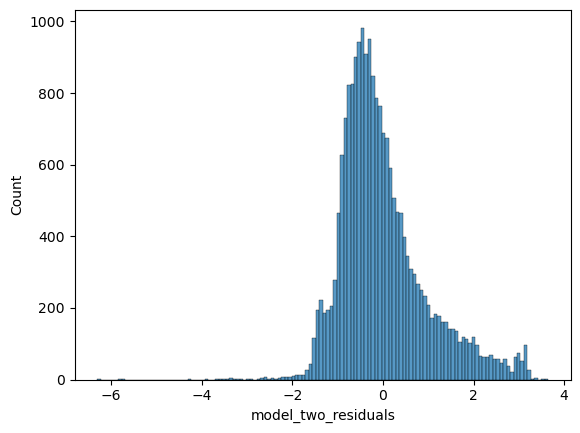

In [96]:
df["model_two_residuals"] = df["housing_price"] - lr_model_two.predict(df[desirable_cities.keys()])

sns.histplot(df["model_two_residuals"])

In [95]:
px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_two_residuals")

## Third Model: Nearest Neighbors
Considering the average housing prices of the 8 nearest housing units models 79% of the pricing variation.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(df[["Latitude", "Longitude"]], df["housing_price"])

gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid={"n_neighbors":[2,3,4,5,10,15,30]}, cv=5)

gs.fit(X_train, y_train)

gs.score(X_test, y_test)


0.7936816628780865

<Axes: xlabel='model_three_residuals', ylabel='Count'>

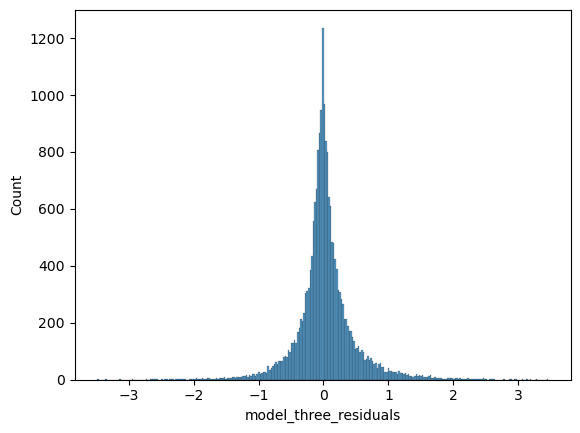

In [110]:
df["model_three_residuals"] = df["housing_price"] - gs.predict(df[["Latitude", "Longitude"]])
sns.histplot(df["model_three_residuals"])

In [111]:
px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_three_residuals")

## Conclusion
It turns out that the best predictor of a housing price is the average price of the 5 nearest blocks.  Since housing is often built in developments of similar housing, it makes sense that the neighborhood would have the strongest effect on housing price.